# Text classification with TensorFlow Hub: Movie reviews

This notebook classifies movie reviews as *positive* or *negative* using the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

The tutorial demonstrates the basic application of transfer learning with [TensorFlow Hub](https://tfhub.dev) and Keras.

It uses the [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews. 

This notebook uses [`tf.keras`](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow, and [`tensorflow_hub`](https://www.tensorflow.org/hub), a library for loading trained models from [TFHub](https://tfhub.dev) in a single line of code. For a more advanced text classification tutorial using `tf.keras`, see the [MLCC Text Classification Guide](https://developers.google.com/machine-learning/guides/text-classification/).

In [1]:
!pip install tensorflow-hub
!pip install tensorflow-datasets

In [3]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Tensorflow Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Tensorflow Version:  2.7.0
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


## Download the IMDB dataset

The IMDB dataset is available on [imdb reviews](https://www.tensorflow.org/datasets/catalog/imdb_reviews) or on [TensorFlow datasets](https://www.tensorflow.org/datasets). The following code downloads the IMDB dataset to your machine (or the colab runtime):

In [4]:
# Split the training set into 60% and 40% to end up with 15,000 examples
# for training, 10,000 examples for validation and 25,000 examples for testing.
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompletePWZCHI/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompletePWZCHI/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompletePWZCHI/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


## Explore the data 

Let's take a moment to understand the format of the data. Each example is a sentence representing the movie review and a corresponding label. The sentence is not preprocessed in any way. The label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

Let's print first 10 examples.

In [5]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_examples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell 

Let's also print the first 10 labels.

In [6]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])>

## Build the model

The neural network is created by stacking layers—this requires three main architectural decisions:

* How to represent the text?
* How many layers to use in the model?
* How many *hidden units* to use for each layer?

In this example, the input data consists of sentences. The labels to predict are either 0 or 1.

One way to represent the text is to convert sentences into embeddings vectors. Use a pre-trained text embedding as the first layer, which will have three advantages:

*   You don't have to worry about text preprocessing,
*   Benefit from transfer learning,
*   the embedding has a fixed size, so it's simpler to process.

For this example you use a **pre-trained text embedding model** from [TensorFlow Hub](https://tfhub.dev) called [google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2).

There are many other pre-trained text embeddings from TFHub that can be used in this tutorial:

* [google/nnlm-en-dim128/2](https://tfhub.dev/google/nnlm-en-dim128/2) - trained with the same NNLM architecture on the same data as [google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2), but with a larger embedding dimension. Larger dimensional embeddings can improve on your task but it may take longer to train your model.
* [google/nnlm-en-dim128-with-normalization/2](https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2) - the same as [google/nnlm-en-dim128/2](https://tfhub.dev/google/nnlm-en-dim128/2), but with additional text normalization such as removing punctuation. This can help if the text in your task contains additional characters or punctuation.
* [google/universal-sentence-encoder/4](https://tfhub.dev/google/universal-sentence-encoder/4) - a much larger model yielding 512 dimensional embeddings trained with a deep averaging network (DAN) encoder.

And many more! Find more [text embedding models](https://tfhub.dev/s?module-type=text-embedding) on TFHub.

Let's first create a Keras layer that uses a TensorFlow Hub model to embed the sentences, and try it out on a couple of input examples. Note that no matter the length of the input text, the output shape of the embeddings is: `(num_examples, embedding_dimension)`.

In [7]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.5423195 , -0.0119017 ,  0.06337538,  0.06862972, -0.16776837,
        -0.10581174,  0.16865303, -0.04998824, -0.31148055,  0.07910346,
         0.15442263,  0.01488662,  0.03930153,  0.19772711, -0.12215476,
        -0.04120981, -0.2704109 , -0.21922152,  0.26517662, -0.80739075,
         0.25833532, -0.3100421 ,  0.28683215,  0.1943387 , -0.29036492,
         0.03862849, -0.7844411 , -0.0479324 ,  0.4110299 , -0.36388892,
        -0.58034706,  0.30269456,  0.3630897 , -0.15227164, -0.44391504,
         0.19462997,  0.19528408,  0.05666234,  0.2890704 , -0.28468323,
        -0.00531206,  0.0571938 , -0.3201318 , -0.04418665, -0.08550783,
        -0.55847436, -0.23336391, -0.20782952, -0.03543064, -0.17533456],
       [ 0.56338924, -0.12339553, -0.10862679,  0.7753425 , -0.07667089,
        -0.15752277,  0.01872335, -0.08169781, -0.3521876 ,  0.4637341 ,
        -0.08492756,  0.07166859, -0.00670817,  0.12686075, -0.19326553,
 

Let's now build the full model:

In [8]:
model = tf.keras.Sequential()
model.add(hub_layer) # The first layer is a TensorFlow Hub layer.
model.add(tf.keras.layers.Dense(16, activation='relu')) # This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.
model.add(tf.keras.layers.Dense(1)) # he last layer is densely connected with a single output node.

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:

1. The first layer is a TensorFlow Hub layer. This layer uses a pre-trained Saved Model to map a sentence into its embedding vector. The pre-trained text embedding model that you are using ([google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2)) splits the sentence into tokens, embeds each token and then combines the embedding. The resulting dimensions are: `(num_examples, embedding_dimension)`. For this NNLM model, the `embedding_dimension` is 50.
2. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units.
3. The last layer is densely connected with a single output node.

Let's compile the model.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs logits (a single-unit layer with a linear activation), you'll use the `binary_crossentropy` loss function.

This isn't the only choice for a loss function, you could, for instance, choose `mean_squared_error`. But, generally, `binary_crossentropy` is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.

Later, when you are exploring regression problems (say, to predict the price of a house), you'll see how to use another loss function called mean squared error.

Now, configure the model to use an optimizer and a loss function:

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model

Train the model for 10 epochs in mini-batches of 512 samples. This is 10 iterations over all samples in the `x_train` and `y_train` tensors. While training, monitor the model's loss and accuracy on the 10,000 samples from the validation set:

In [10]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/10
30/30 [==============================] - 22s 657ms/step - loss: 0.6657 - accuracy: 0.5364 - val_loss: 0.6143 - val_accuracy: 0.6140
Epoch 2/10
30/30 [==============================] - 20s 635ms/step - loss: 0.5439 - accuracy: 0.7008 - val_loss: 0.5032 - val_accuracy: 0.7353
Epoch 3/10
30/30 [==============================] - 19s 631ms/step - loss: 0.4111 - accuracy: 0.8187 - val_loss: 0.4080 - val_accuracy: 0.8059
Epoch 4/10
30/30 [==============================] - 20s 636ms/step - loss: 0.3029 - accuracy: 0.8843 - val_loss: 0.3489 - val_accuracy: 0.8468
Epoch 5/10
30/30 [==============================] - 20s 647ms/step - loss: 0.2226 - accuracy: 0.9201 - val_loss: 0.3169 - val_accuracy: 0.8620
Epoch 6/10
30/30 [==============================] - 20s 644ms/step - loss: 0.1602 - accuracy: 0.9501 - val_loss: 0.3055 - val_accuracy: 0.8673
Epoch 7/10
30/30 [==============================] - 20s 644ms/step - loss: 0.1143 - accuracy: 0.9661 - val_loss: 0.3061 - val_accuracy: 0.8696

## Evaluate the model

And let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [11]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

49/49 - 5s - loss: 0.3630 - accuracy: 0.8544 - 5s/epoch - 97ms/step
loss: 0.363
accuracy: 0.854


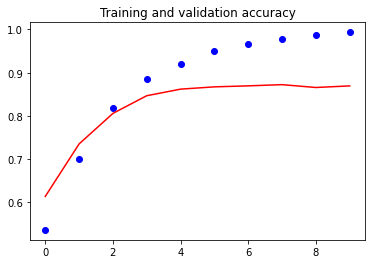

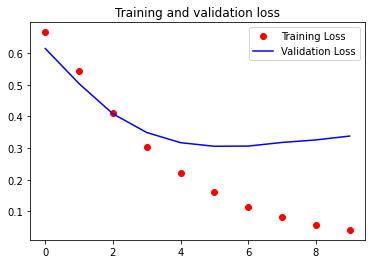

In [14]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

This fairly naive approach achieves an accuracy of about 87%. With more advanced approaches, the model should get closer to 95%.